In [1]:
import os
import numpy as np
import h5py
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

In [2]:
import random
import numpy as np

def apply_transformations(point_cloud, scale_variance=0.1, rotation_variance=0.1, y_rotation_variance=180, jitter_variance=0.01):
    transformed_point_cloud = np.copy(point_cloud)
    
    # Pertimbangkan setiap titik dalam point cloud
    for i in range(len(transformed_point_cloud)):
        # Augmentasi berbasis skala
        scale = 1.0 + scale_variance * np.random.randn(1)
        transformed_point_cloud[i] *= scale

        # Augmentasi berbasis rotasi
        theta = rotation_variance * np.pi / 180 * np.random.randn(3)
        theta_y = y_rotation_variance * np.pi / 180 * np.random.randn(3)
        rotation_matrix = np.array([[1, 0, 0],
                                    [0, np.cos(theta[0]), -np.sin(theta[0])],
                                    [0, np.sin(theta[0]), np.cos(theta[0])]])
        rotation_matrix = np.dot(np.array([[np.cos(theta_y[1]), 0, np.sin(theta_y[1])],
                                          [0, 1, 0],
                                          [-np.sin(theta_y[1]), 0, np.cos(theta_y[1])]]), rotation_matrix)
        rotation_matrix = np.dot(np.array([[np.cos(theta[2]), -np.sin(theta[2]), 0],
                                          [np.sin(theta[2]), np.cos(theta[2]), 0],
                                          [0, 0, 1]]), rotation_matrix)
        transformed_point_cloud[i] = np.dot(transformed_point_cloud[i], rotation_matrix)

        # Augmentasi berbasis jitter global
        jitter = jitter_variance * np.random.randn(1, 3)
        transformed_point_cloud[i] += jitter

    # Augmentasi berbasis jitter lokal
    jitter = jitter_variance * np.random.randn(*transformed_point_cloud.shape)
    transformed_point_cloud += jitter

    return transformed_point_cloud


In [3]:
import open3d as o3d

def data_test_transform(point_clouds, scale_variance=0.1, rotation_variance=0.1, y_rotation_variance=180,
                        jitter_variance=0.01, norm_rot=True):
    transformed_point_clouds = []

    # Pertimbangkan setiap titik dalam point clouds
    for i, point_cloud in enumerate(point_clouds):
        # Generate a unique seed for each data point
        seed = i + 1  # You can modify this seed generation logic based on your requirements

        # Set the seed
        np.random.seed(seed)

        transformed_point_cloud = np.copy(point_cloud)

        if norm_rot:
            # Apply PCA to determine the main orientation
            cov_matrix = np.cov(transformed_point_cloud, rowvar=False)
            _, _, eigen_vectors = np.linalg.svd(cov_matrix)
            main_orientation = eigen_vectors[:, 2]  # Ambil vektor eigen yang sesuai dengan sumbu Z

            # Compute rotation matrix to align main orientation with Z-axis
            rotation_matrix = o3d.geometry.get_rotation_matrix_from_xyz((0, -np.arctan2(main_orientation[1], main_orientation[0]), 0))

            # Convert numpy array to Open3D PointCloud
            transformed_point_cloud_o3d = o3d.geometry.PointCloud()
            transformed_point_cloud_o3d.points = o3d.utility.Vector3dVector(transformed_point_cloud)

            # Apply rotation to the PointCloud
            transformed_point_cloud_o3d.rotate(rotation_matrix, center=(0, 0, 0))

            # Convert back to numpy array
            transformed_point_cloud = np.asarray(transformed_point_cloud_o3d.points)

        # Augmentasi berbasis skala
        scale = 1.0 + scale_variance * np.random.randn(1)
        transformed_point_cloud *= scale

        # Augmentasi berbasis rotasi
        theta = rotation_variance * np.pi / 180 * np.random.randn(3)
        theta_y = y_rotation_variance * np.pi / 180 * np.random.randn(3)
        rotation_matrix = np.array([[1, 0, 0],
                                    [0, np.cos(theta[0]), -np.sin(theta[0])],
                                    [0, np.sin(theta[0]), np.cos(theta[0])]])
        rotation_matrix = np.dot(np.array([[np.cos(theta_y[1]), 0, np.sin(theta_y[1])],
                                          [0, 1, 0],
                                          [-np.sin(theta_y[1]), 0, np.cos(theta_y[1])]]), rotation_matrix)
        rotation_matrix = np.dot(np.array([[np.cos(theta[2]), -np.sin(theta[2]), 0],
                                          [np.sin(theta[2]), np.cos(theta[2]), 0],
                                          [0, 0, 1]]), rotation_matrix)
        transformed_point_cloud = np.dot(transformed_point_cloud, rotation_matrix)

        # Augmentasi berbasis jitter global
        jitter = jitter_variance * np.random.randn(3)
        transformed_point_cloud += jitter

        # Augmentasi berbasis jitter lokal
        jitter = jitter_variance * np.random.randn(*transformed_point_cloud.shape)
        transformed_point_cloud += jitter

        transformed_point_clouds.append(transformed_point_cloud)

        # print("Index:", i)
        # print("Derajat Rotasi X, Y, Z:", theta * 180 / np.pi)
        # print("Derajat Rotasi Y (tambahan):", theta_y * 180 / np.pi)

    return np.array(transformed_point_clouds)


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
# Load dataset
def load_data(file_path):
    with h5py.File(file_path, 'r') as f:
        data = f['data'][:]
        label = f['label'][:]
    return data, label

def load_all_data(train_files, test_files):
    train_data = []
    train_label = []
    test_data = []
    test_label = []

    for filename in train_files:
        data, label = load_data(filename)
        train_data.append(data)
        train_label.append(label)

    for filename in test_files:
        data, label = load_data(filename)
        test_data.append(data)
        test_label.append(label)

    train_data = np.concatenate(train_data, axis=0)
    train_label = np.concatenate(train_label, axis=0)
    test_data = np.concatenate(test_data, axis=0)
    test_label = np.concatenate(test_label, axis=0)

    return train_data, train_label, test_data, test_label

# Load train and test file names
train_files = np.loadtxt('train_files.txt', dtype=str)
test_files = np.loadtxt('test_files.txt', dtype=str)

# Load data
train_data, train_label, test_data, test_label = load_all_data(train_files, test_files)

In [5]:
import open3d as o3d
import numpy as np

# Visualize a point cloud using Open3D
def visualize_point_cloud(points):
    # Create Open3D point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    # Visualize the point cloud
    o3d.visualization.draw_plotly([pcd])

# Choose an index for visualization (adjust as needed)
train_index = 2050  # index of the object in the training set
test_index = 2080   # index of the object in the test set

# Visualize an object from the training set
visualize_point_cloud(train_data[train_index])

# Visualize an object from the test set
visualize_point_cloud(test_data[test_index])

Jumlah data : 9840
Testing augmentasi data :


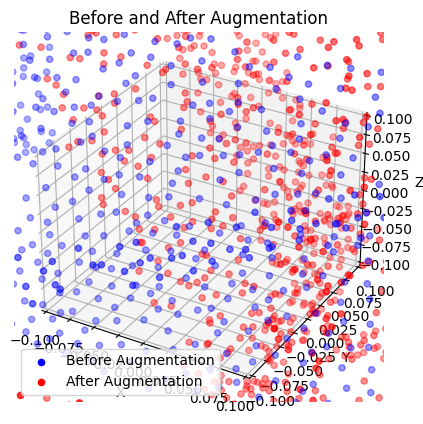

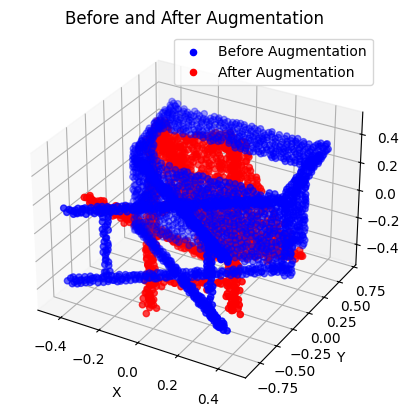

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def visualize_aug_point_cloud(point_cloud_before, point_cloud_after, title_before, title_after):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot Before Augmentation
    ax.scatter(point_cloud_before[:, 0], point_cloud_before[:, 1], point_cloud_before[:, 2], c='b', marker='o', label=title_before)

    # Plot After Augmentation
    ax.scatter(point_cloud_after[:, 0], point_cloud_after[:, 1], point_cloud_after[:, 2], c='r', marker='o', label=title_after)

    ax.set_title('Before and After Augmentation')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xlim([-0.1, 0.1])  # Sesuaikan dengan rentang sumbu agar titik dapat terlihat
    ax.set_ylim([-0.1, 0.1])
    ax.set_zlim([-0.1, 0.1])
    ax.legend()
    plt.show()

def visualize_before_after(point_cloud_before, point_cloud_after, title_before, title_after):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot Before Augmentation
    ax.scatter(point_cloud_before[:, 0], point_cloud_before[:, 1], point_cloud_before[:, 2], c='b', marker='o', label=title_before)

    # Plot After Augmentation
    ax.scatter(point_cloud_after[:, 0], point_cloud_after[:, 1], point_cloud_after[:, 2], c='r', marker='o', label=title_after)

    ax.set_title('Before and After Augmentation')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()

print('Jumlah data :', len(train_data))
index_to_visualize = 2050

# Test augmentasi data
print('Testing augmentasi data :')
augmented_data = apply_transformations(train_data)

# Visualisasi Before dan After Augmentation
visualize_aug_point_cloud(train_data[index_to_visualize], augmented_data[index_to_visualize], 'Before Augmentation', 'After Augmentation')

# Visualisasi Before dan After Augmentation
visualize_before_after(train_data[index_to_visualize], augmented_data[index_to_visualize], 'Before Augmentation', 'After Augmentation')


In [7]:
import open3d as o3d
import numpy as np

train_data = apply_transformations(train_data)
test_data = data_test_transform(test_data)

# Preprocess data
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')
num_classes = len(np.unique(train_label))
train_label = to_categorical(train_label, num_classes)
test_label = to_categorical(test_label, num_classes)

# Choose an index for visualization (adjust as needed)
train_index = 2050  # index of the object in the training set
test_index = 2080   # index of the object in the test set

# Visualize an object from the training set
visualize_point_cloud(train_data[train_index])

# Visualize an object from the test set
visualize_point_cloud(test_data[test_index])

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, BatchNormalization, MaxPooling1D, GlobalMaxPooling1D, Dropout, Reshape
import tensorflow as tf
from tensorflow.keras.layers import Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, History
import matplotlib.pyplot as plt

def orthogonal_regularizer(weight_matrix):
    """
    Regularizer to enforce orthogonality of the weight matrix.
    """
    eps = 1e-10
    w_dot_w_transpose = tf.matmul(weight_matrix, tf.transpose(weight_matrix))
    identity_matrix = tf.eye(tf.shape(w_dot_w_transpose)[0])
    orthogonality_loss = tf.reduce_sum(tf.square(w_dot_w_transpose - identity_matrix))
    return eps * orthogonality_loss

def TNet(input_points, output_size):
    # T-Net for learning transformation matrix
    x = Conv1D(64, 1, activation='relu')(input_points)
    x = BatchNormalization()(x)
    x = Conv1D(128, 1, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv1D(1024, 1, activation='relu')(x)
    x = BatchNormalization()(x)
    x = GlobalMaxPooling1D()(x)
    
    x = Dense(512, activation='relu', kernel_regularizer=orthogonal_regularizer)(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu', kernel_regularizer=orthogonal_regularizer)(x)
    x = BatchNormalization()(x)
    x = Dense(output_size * output_size, kernel_regularizer=orthogonal_regularizer)(x)
    transformation_matrix = Reshape((output_size, output_size))(x)

    return transformation_matrix

def PointNet(input_size, num_classes):
    input_points = Input(shape=(input_size, 3))

    # Transformation Net 1
    matrix_1 = TNet(input_points, 3)
    # Apply the transformation to input points
    transformed_points = tf.matmul(input_points, matrix_1)

    # Input transformation
    x = Conv1D(64, 1, activation='relu')(transformed_points)
    x = BatchNormalization()(x)
    x = Conv1D(64, 1, activation='relu')(x) # mlp(64,64)
    x = BatchNormalization()(x)

    # Transformation Net 2
    matrix_2 = TNet(x, 64) # feature transformation
    # Apply the transformation to point features
    transformed_features = tf.matmul(x, matrix_2)

    # Feature extraction
    x = Conv1D(64, 1, activation='relu')(transformed_features)
    x = BatchNormalization()(x)
    x = Conv1D(128, 1, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv1D(1024, 1, activation='relu')(x)
    x = BatchNormalization()(x)
    x = GlobalMaxPooling1D()(x)

    # Fully connected layers
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_points, outputs=x)

    return model

# Example usage
input_size = 2048  # adjust based on your dataset
num_classes = 40   # adjust based on your dataset
model = PointNet(input_size, num_classes)

# Callback untuk menyimpan model terbaik
model_checkpoint = ModelCheckpoint('trained/best/best_model-aug_final_v7-200.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max', verbose=1)

# Callback untuk menyimpan riwayat pelatihan
history_callback = History()

# Fungsi untuk plotting grafik akurasi dan loss
def plot_history(history):
    plt.figure(figsize=(12, 6))

    # Plot akurasi
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 2048, 64)     256         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 2048, 64)    256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv1d_1 (Conv1D)              (None, 2048, 128)    8320        ['batch_normalization[0][0]']

In [9]:
# Train model
history = model.fit(train_data, train_label, batch_size=32, epochs=200, shuffle=True, validation_data=(test_data, test_label), callbacks=[model_checkpoint, history_callback])


Epoch 1/200
308/308 [==============================] - ETA: 0s - loss: 3.0524 - accuracy: 0.2407
Epoch 1: val_accuracy improved from -inf to 0.04457, saving model to trained/best\best_model-aug_final_v7-200.h5
308/308 [==============================] - 73s 226ms/step - loss: 3.0524 - accuracy: 0.2407 - val_loss: 4.4915 - val_accuracy: 0.0446
Epoch 2/200
308/308 [==============================] - ETA: 0s - loss: 2.1984 - accuracy: 0.3918
Epoch 2: val_accuracy improved from 0.04457 to 0.32253, saving model to trained/best\best_model-aug_final_v7-200.h5
308/308 [==============================] - 69s 225ms/step - loss: 2.1984 - accuracy: 0.3918 - val_loss: 2.5075 - val_accuracy: 0.3225
Epoch 3/200
308/308 [==============================] - ETA: 0s - loss: 1.7937 - accuracy: 0.4868
Epoch 3: val_accuracy improved from 0.32253 to 0.43558, saving model to trained/best\best_model-aug_final_v7-200.h5
308/308 [==============================] - 69s 225ms/step - loss: 1.7937 - accuracy: 0.4868 - va

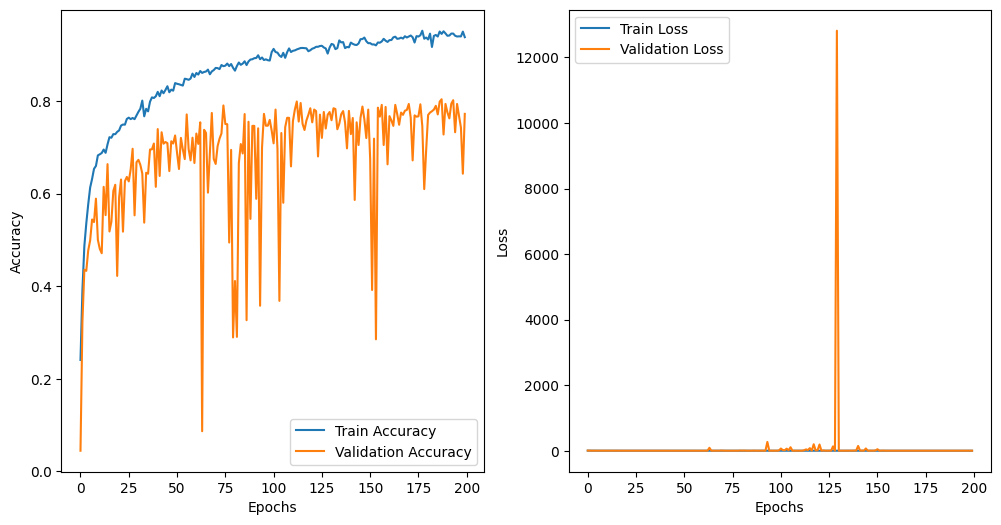

In [10]:
# Plot history
plot_history(history)

In [11]:
# Evaluate model
# score = model.evaluate(test_data, test_label, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

In [12]:
# Save the entire model as a `.keras` zip archive.
# model.save(f"trained/best/best_model.h5")

78/78 [==============================] - 4s 41ms/step


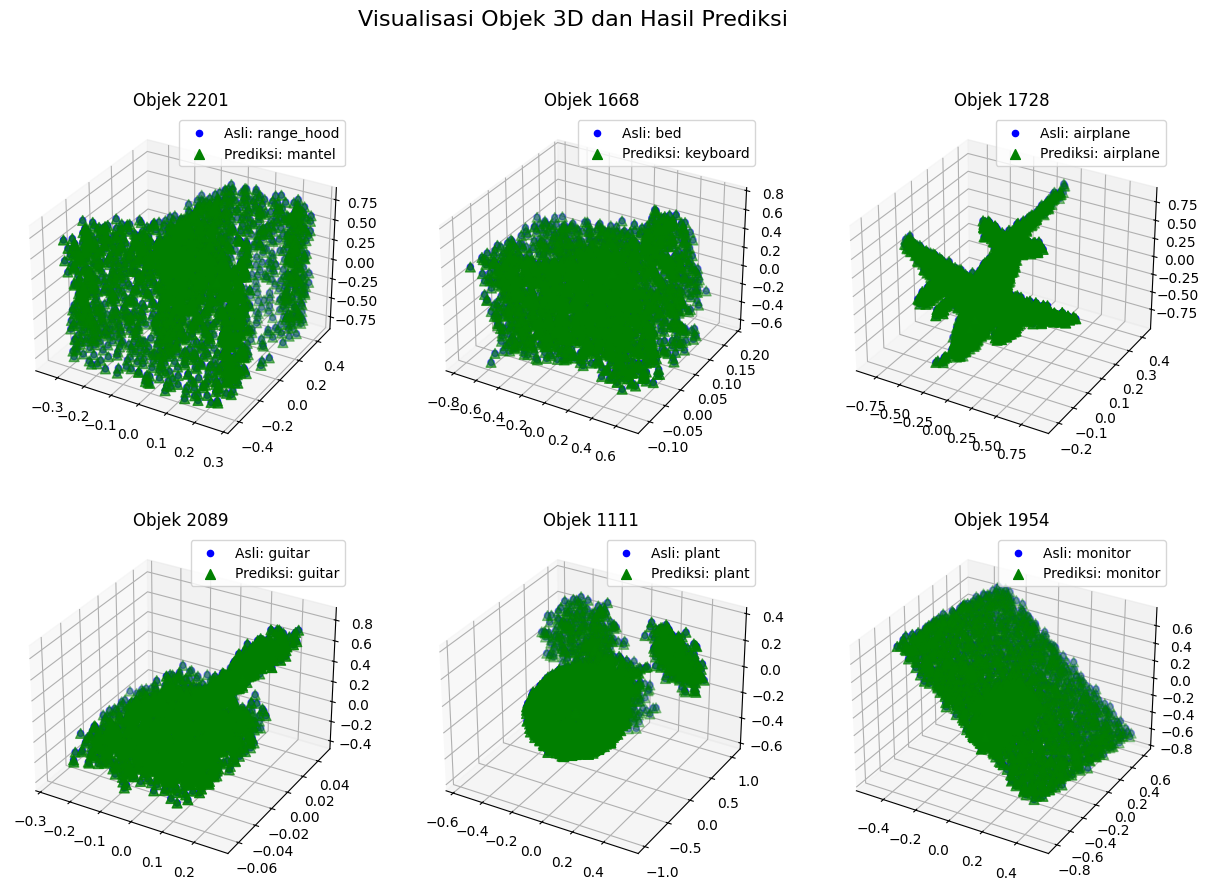

In [13]:
import matplotlib.pyplot as plt
import random

# Load shape names
with open('data/modelnet40_ply_hdf5_2048/shape_names.txt', 'r') as f:
    shape_names = f.readlines()
shape_names = [shape_name.strip() for shape_name in shape_names]

# Use trained model for prediction
predictions = model.predict(test_data)

# Select a few samples for visualization
# sample_indices = [2, 5, 8, 12, 15, 20]  # Ganti dengan indeks yang diinginkan
sample_indices = random.sample(range(len(test_data)), 6)
fig = plt.figure(figsize=(15, 10))
fig.suptitle('Visualisasi Objek 3D dan Hasil Prediksi', fontsize=16)

for i, index in enumerate(sample_indices):
    ax = fig.add_subplot(2, 3, i + 1, projection='3d')
    ax.set_title(f'Objek {index}')
    ax.scatter(test_data[index][:, 0], test_data[index][:, 1], test_data[index][:, 2], c='b', marker='o', s=20, label=f'Asli: {shape_names[np.argmax(test_label[index])]}')
    ax.scatter(test_data[index][:, 0], test_data[index][:, 1], test_data[index][:, 2], c='g', marker='^', s=50, label=f'Prediksi: {shape_names[np.argmax(predictions[index])]}')
    ax.legend()

plt.show()


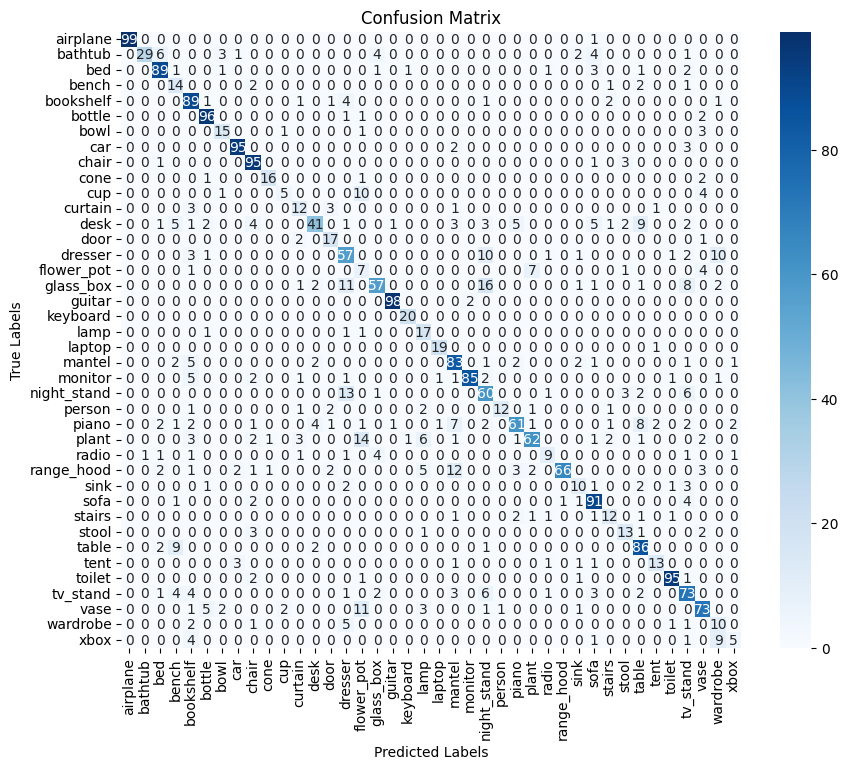

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert predictions and test labels to class indices
predicted_indices = np.argmax(predictions, axis=1)
test_indices = np.argmax(test_label, axis=1)

# Create confusion matrix
cm = confusion_matrix(test_indices, predicted_indices)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=shape_names, yticklabels=shape_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [15]:
import open3d as o3d

# Load and preprocess single point cloud data
def load_and_preprocess_ply(file_path):
    # ply_data = o3d.io.read_point_cloud(file_path)
    # points = np.asarray(ply_data.points)
    # points = np.expand_dims(points, axis=0)
    # points = points.astype('float32')
    # return points

    # Load point cloud data
    ply_data = o3d.io.read_point_cloud(file_path)

    # Remove statistical outliers
    cl, ind = ply_data.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)

    # Voxel downsampling for uniform sampling
    downsampled_ply_data = cl.voxel_down_sample(voxel_size=0.005)

    # Normalize the point cloud data
    downsampled_points = np.asarray(downsampled_ply_data.points)
    centroid = np.mean(downsampled_points, axis=0)
    downsampled_points -= centroid
    scale = np.max(np.linalg.norm(downsampled_points, axis=1))
    downsampled_points /= scale

    # Prepare the preprocessed point cloud data
    points = np.expand_dims(downsampled_points, axis=0)
    points = points.astype('float32')

    return points

# Example input file path, change this to the path of your input file
input_ply_file = 'objects/cropped/Plant01_rotated.ply'

# Load and preprocess the input ply file
input_data = load_and_preprocess_ply(input_ply_file)

# Use the model for prediction
prediction = model.predict(input_data)

import pythreejs as three
from IPython.display import display

# Generate colors for gradient effect
def generate_color_gradient(data):
    max_value = np.amax(data, axis=0)
    min_value = np.amin(data, axis=0)
    normalized_data = (data - min_value) / (max_value - min_value)

    colors = np.zeros((normalized_data.shape[0], 3))
    colors[:, 0] = normalized_data[:, 0]  # R values
    colors[:, 1] = normalized_data[:, 1]  # G values
    colors[:, 2] = normalized_data[:, 2]  # B values

    return colors.tolist()

# Visualize the point cloud data in Jupyter Notebook with color gradient
def visualize_point_cloud_with_color_gradient(data):
    colors = generate_color_gradient(data)

    points_geometry = three.BufferGeometry(
        attributes={
            "position": three.BufferAttribute(data, normalized=False),
            "color": three.BufferAttribute(colors, normalized=False)
        }
    )

    points_material = three.PointsMaterial(
        size=0.05,
        vertexColors='VertexColors'
    )

    points = three.Points(geometry=points_geometry, material=points_material)

    scene = three.Scene(children=[points, three.AmbientLight(color='#777777')])

    camera = three.PerspectiveCamera(position=[2, 1, 2], up=[0, 1, 0], aspect=1)

    key_light = three.DirectionalLight(position=[3, 5, 1], intensity=0.6)
    ambient_light = three.AmbientLight(intensity=0.6)

    c = three.Renderer(camera=camera, scene=scene, controls=[three.OrbitControls(controlling=camera)])
    c.width = 500
    c.height = 500

    display(c)

# Print the prediction
predicted_class = shape_names[np.argmax(prediction)]
print(f'Predicted class: {predicted_class}')

# Visualize the point cloud data with color gradient
visualize_point_cloud_with_color_gradient(input_data[0])

1/1 [==============================] - 0s 310ms/step
Predicted class: plant


Renderer(camera=PerspectiveCamera(position=(2.0, 1.0, 2.0), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.…